# I - Data preparation

Import Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import cv2
import random
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

Split image data into Train and Test

In [2]:
def create_train_test(data_path,class_name,train_size,test_size):
    directory = data_path + class_name + "/"
    print("Browsing directory "+directory)
    data = os.listdir(directory)
    random.shuffle(data) 
    train = data[:train_size] # take the first train_size images of each class for training
    test = data[train_size:train_size+test_size] # take the next test_size images for testing
    return train, test

class_list = []
data_path = "CBIR_15-Scene/"
for file in sorted(os.listdir(data_path)):
    if os.path.isdir(data_path+file):
        class_list.append(file)        
        
train_size = 10
test_size = 5
train_set = []
test_set = []
train_set_label = []
test_set_label = []
for class_name in class_list:
    train, test = create_train_test(data_path,class_name,train_size,test_size)
    train_set = train_set + train # These are the lists of image file names
    test_set = test_set + test
    train_label = [class_name] * len(train)
    test_label = [class_name] * len(test)
    train_set_label = train_set_label + train_label # These are the lists of directory names (labels)
    test_set_label = test_set_label + test_label

print("Size of training set: ",len(train_set))
print("Size of testing set: ",len(test_set))

Browsing directory CBIR_15-Scene/00/
Browsing directory CBIR_15-Scene/01/
Browsing directory CBIR_15-Scene/02/
Browsing directory CBIR_15-Scene/03/
Browsing directory CBIR_15-Scene/04/
Browsing directory CBIR_15-Scene/05/
Browsing directory CBIR_15-Scene/06/
Browsing directory CBIR_15-Scene/07/
Browsing directory CBIR_15-Scene/08/
Browsing directory CBIR_15-Scene/09/
Browsing directory CBIR_15-Scene/10/
Browsing directory CBIR_15-Scene/11/
Browsing directory CBIR_15-Scene/12/
Browsing directory CBIR_15-Scene/13/
Browsing directory CBIR_15-Scene/14/
Size of training set:  150
Size of testing set:  75


# II - Computing local descriptors on training set

## KAZE:

The KAZE algorithm identifies keypoints using a nonlinear scale-space representation, which enhances its ability to detect features in highly textured regions. It provides scale invariance and partial invariance to affine transformations, making it robust to changes in scale and moderate geometric distortions. The descriptors used by KAZE are based on Modified Local Difference Binary (MLDB), a method designed to balance computational efficiency with descriptor quality.

In the provided code, KAZE’s performance is influenced by parameters such as scale-space and diffusivity, which allow fine-tuning of the algorithm to adjust the sensitivity of feature detection and its robustness across different image types. These parameters enable it to capture intricate details that might be overlooked by other detectors.

KAZE excels in scenarios where detecting fine-grained details is critical, such as in landscapes, cityscapes, or other images with complex textures. While it tends to be computationally slower compared to algorithms like ORB, it offers superior precision in identifying and describing features, particularly in challenging visual environments.

Due to its ability to detect detailed and reliable features, KAZE is particularly well-suited for applications that require high-quality feature detection, such as content-based image retrieval, image stitching, or detailed object recognition. This trade-off between computational speed and precision makes it a preferred choice for tasks where accuracy outweighs the need for real-time processing.

## ORB:

The ORB algorithm (Oriented FAST and Rotated BRIEF) integrates the FAST keypoint detection method with the BRIEF descriptor, resulting in a highly efficient algorithm optimized for speed and real-time performance. Unlike its individual components, ORB enhances the robustness of BRIEF by adding rotational invariance, achieved by calculating the orientation of detected keypoints. Additionally, it uses a binary descriptor, making it both compact and computationally lightweight.

In the code, ORB offers configurable parameters such as the number of features, scale factor, and pyramid levels. These parameters allow fine-tuning of the algorithm to balance accuracy and computational cost, making it flexible for various use cases where resources are limited.

ORB is particularly effective for images with simpler or less textured content, where speed and robustness are prioritized over intricate detail. While it generally detects and describes fewer keypoints compared to KAZE, its computational efficiency makes it ideal for applications with stringent time or resource constraints.

Due to its speed and compact descriptors, ORB is well-suited for scenarios requiring real-time performance, such as in mobile or embedded systems, augmented reality, video tracking, or lightweight computer vision tasks. Its ability to deliver reliable results with minimal computational overhead makes it a go-to choice for applications where efficiency is paramount.

In [3]:
results = []

for method in ["kaze", "orb"]:
    if method == "kaze":
        kp = cv2.KAZE_create()
    elif method == "orb":
        kp = cv2.ORB_create(nfeatures=200, scaleFactor=2, nlevels=3)

    print(f"\nRunning analysis for method: {method.upper()}")

    total_keypoints = 0
    total_time = 0
    descriptor_dimensions = None

    for class_name in class_list[:5]:  # Limit to first 5 classes for speed
        img_file = data_path + test_set_label[0] + "/" + test_set[0]
        img = cv2.imread(img_file)

        if img is None:
            print(f"Error loading image: {img_file}")
            continue

        # Time the keypoint detection
        start_time = time.time()
        pts, desc = kp.detectAndCompute(img, None)
        end_time = time.time()

        # Aggregate results
        total_keypoints += len(pts)
        total_time += (end_time - start_time)

        # Record descriptor dimension
        if desc is not None and descriptor_dimensions is None:
            descriptor_dimensions = desc.shape[1]

        print(f"{method.upper()} - {class_name}: {len(pts)} keypoints, Time: {end_time - start_time:.4f}s")

    # Compute averages
    avg_keypoints = total_keypoints / len(class_list[:5])
    avg_time = total_time / len(class_list[:5])
    results.append({
        "method": method.upper(),
        "avg_keypoints": avg_keypoints,
        "avg_time": avg_time,
        "descriptor_dimensions": descriptor_dimensions
    })

# Print summary
for result in results:
    print(f"\n{result['method']} Summary:")
    print(f"  Average Keypoints: {result['avg_keypoints']:.2f}")
    print(f"  Average Time: {result['avg_time']:.4f}s")
    print(f"  Descriptor Dimensions: {result['descriptor_dimensions']}")


Running analysis for method: KAZE
KAZE - 00: 252 keypoints, Time: 0.0227s
KAZE - 01: 252 keypoints, Time: 0.0163s
KAZE - 02: 252 keypoints, Time: 0.0136s
KAZE - 03: 252 keypoints, Time: 0.0146s
KAZE - 04: 252 keypoints, Time: 0.0142s

Running analysis for method: ORB
ORB - 00: 171 keypoints, Time: 0.1157s
ORB - 01: 171 keypoints, Time: 0.0019s
ORB - 02: 171 keypoints, Time: 0.0006s
ORB - 03: 171 keypoints, Time: 0.0012s
ORB - 04: 171 keypoints, Time: 0.0006s

KAZE Summary:
  Average Keypoints: 252.00
  Average Time: 0.0163s
  Descriptor Dimensions: 64

ORB Summary:
  Average Keypoints: 171.00
  Average Time: 0.0240s
  Descriptor Dimensions: 32


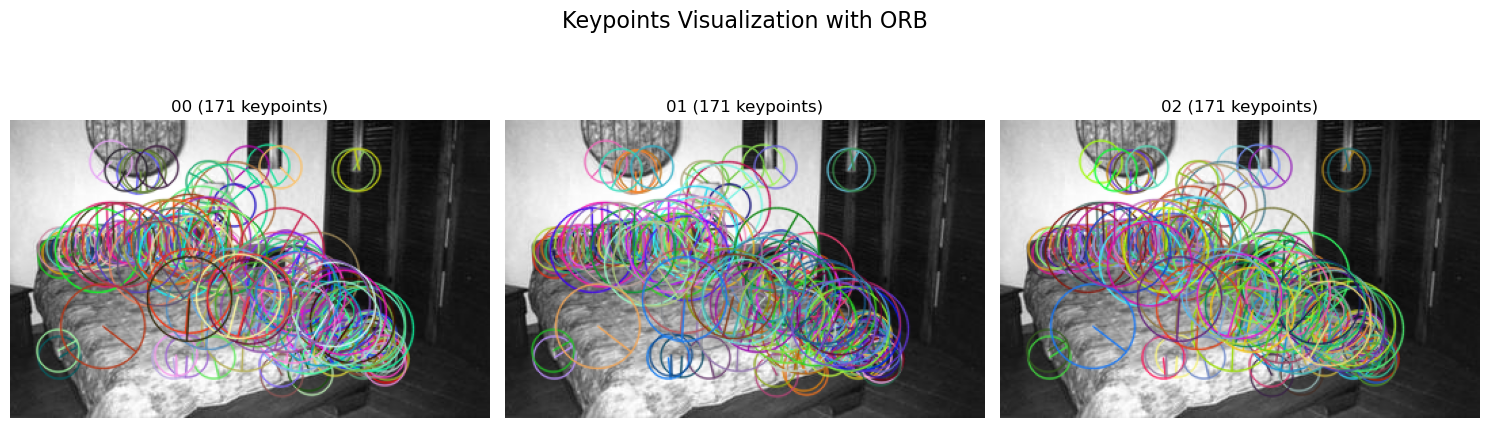

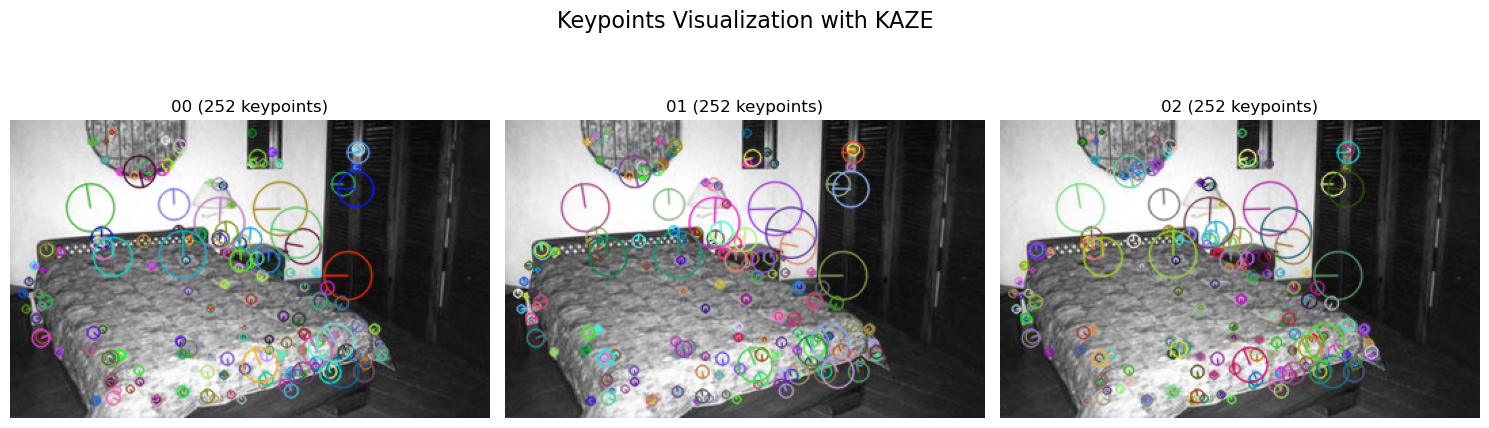

In [4]:
for method in ["orb", "kaze"]:
    if method == "kaze":
        kp = cv2.KAZE_create()
    elif method == "orb":
        kp = cv2.ORB_create(nfeatures=200, scaleFactor=2, nlevels=3)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Keypoints Visualization with {method.upper()}", fontsize=16)

    for idx, class_name in enumerate(class_list[:3]):  # First 3 classes for visualization
        img_file = data_path + test_set_label[0] + "/" + test_set[0]
        img = cv2.imread(img_file)

        if img is None:
            print(f"Error loading image: {img_file}")
            continue

        pts, _ = kp.detectAndCompute(img, None)
        img_disp = cv2.drawKeypoints(img, pts, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        axes[idx].imshow(cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB))
        axes[idx].set_title(f"{class_name} ({len(pts)} keypoints)")
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()

Number of descriptors:  52084
Dimension of descriptors:  64
Type of descriptors:  float32
Average computation time per image: 15.53 ms


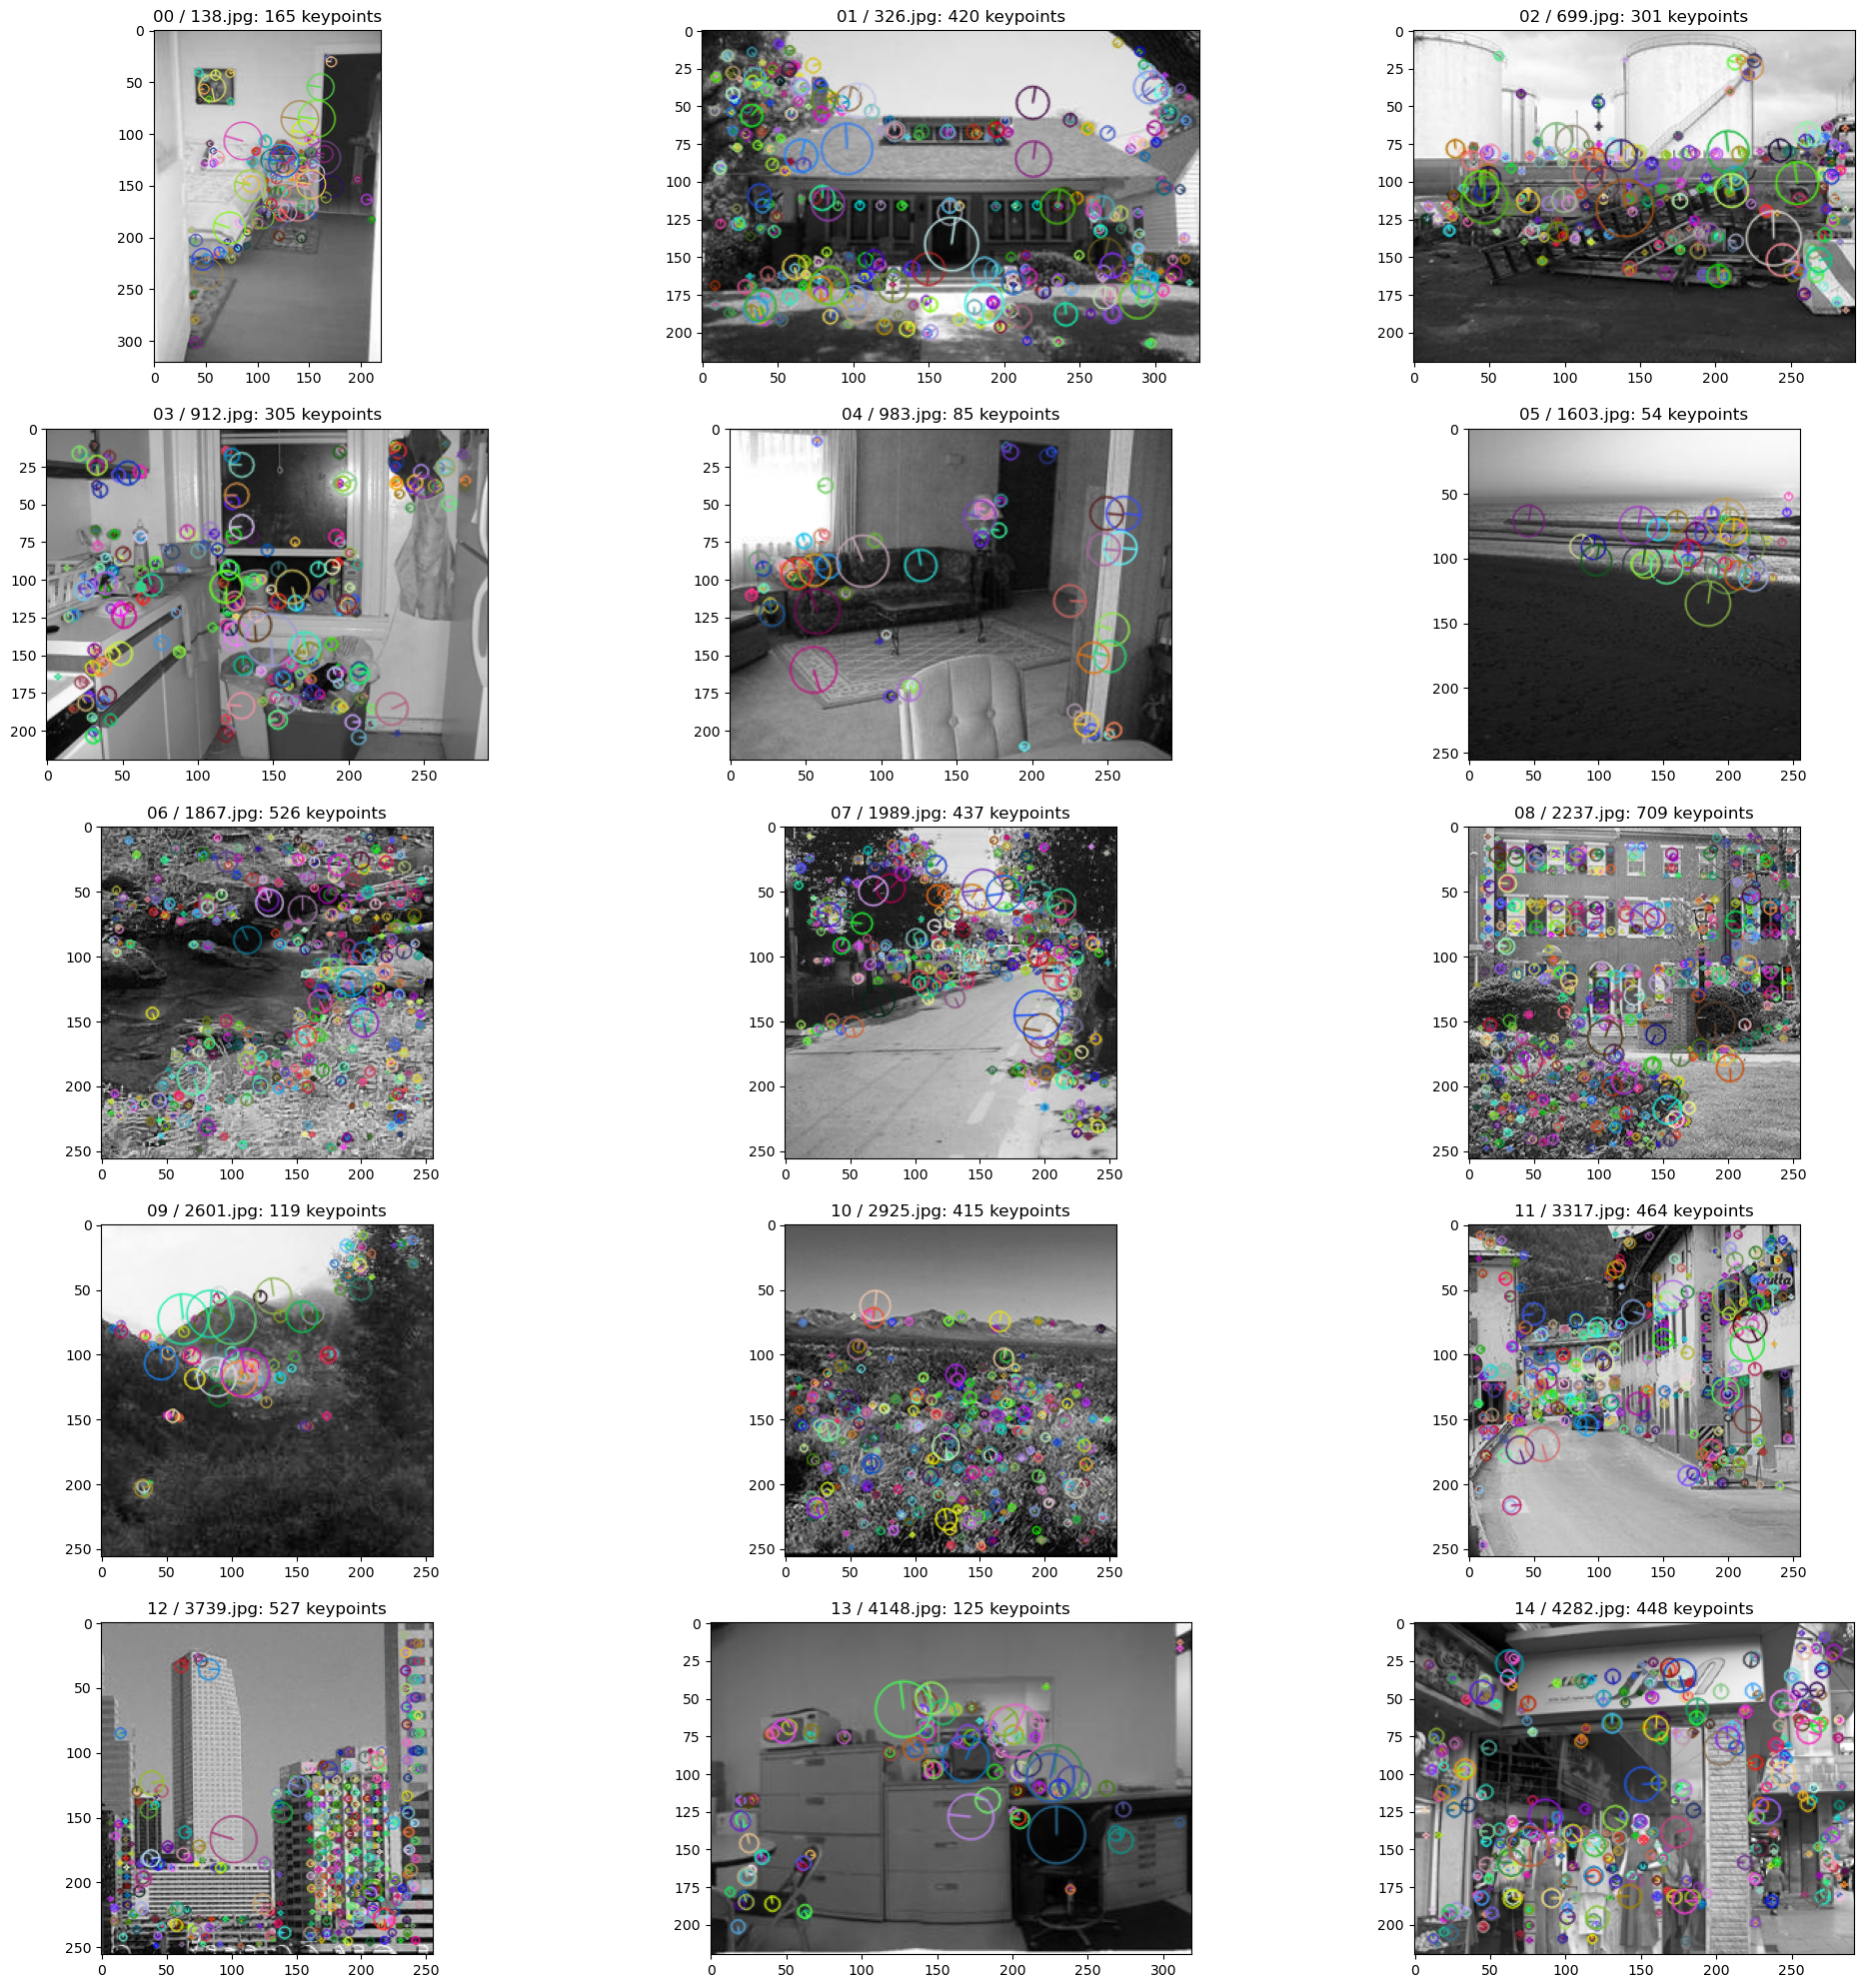

In [5]:
f, disp_array = plt.subplots(5,3,figsize=(25,25))
old_label = "FIRST"
[lig, col] = [0,0]
t1 = cv2.getTickCount() #OpenCV method for estimating computation time

for i in range(len(train_set)):
    img_file = data_path + train_set_label[i] + "/" + train_set[i]
    img = cv2.imread(img_file)
    #print("Dimension of image",img.shape[0],"rows x",img.shape[1],"columns")
    #print("Type of image:",img.dtype)
    pts, desc = kp.detectAndCompute(img, mask=None)
    if (old_label == "FIRST"):
        descriptors_dataset = desc
    else:
        descriptors_dataset = np.vstack((descriptors_dataset,desc))
    img_disp = cv2.drawKeypoints(img, pts, None, flags=4)
    if (train_set_label[i] != old_label): # Display keypoints as examples for first image of each class
        old_label = train_set_label[i]
        disp_array[lig,col].imshow(img_disp)
        nb_kp = str(desc.shape[0]) # Number of keypoints in one image
        disp_array[lig,col].title.set_text(train_set_label[i] + " / " + train_set[i] + ": " + nb_kp + " keypoints")
        col = col + 1
        if (col == 3):
            [lig,col] = [lig+1,0]

t2 = cv2.getTickCount()
time = (t2 - t1)/ cv2.getTickFrequency()

print("Number of descriptors: ",descriptors_dataset.shape[0])
print("Dimension of descriptors: ",descriptors_dataset.shape[1])
print("Type of descriptors: ",descriptors_dataset.dtype)
print("Average computation time per image:",round((1000*time)/len(train_set),2),"ms")

# III - Dictionary creation (here K-Means Clustering)

## Codebook Construction: Clustering and Determining the Codebook Size

### Building the Codebook

To construct the codebook, the first step is to apply a clustering method to group similar descriptors into clusters. By default, K-Means Clustering is commonly used for this purpose. Each cluster center produced by the algorithm represents a “visual word” in the codebook, which is essential for content-based image retrieval. However, if K-Means does not perform well with the data or computational needs, alternative clustering methods such as DBSCAN, Gaussian Mixture Models (GMM), or Hierarchical Clustering can be explored. These methods may provide additional flexibility or better results depending on the characteristics of the descriptors.

The input for the clustering process consists of descriptors extracted from all training images. These descriptors are computed using a chosen keypoint detection method, such as KAZE or ORB. The quality and quantity of these descriptors significantly influence the performance of the clustering process and the resulting codebook.

### Rule of Thumb for Codebook Size

Determining the size of the codebook, or the number of clusters in K-Means, is a critical decision that directly affects the system’s performance. This size must strike a balance between representation power and computational efficiency. The following factors are key considerations when setting the codebook size:
1. **Number of Classes (C):**
The number of image classes in the dataset serves as a baseline for estimating the codebook size. Ideally, each class should have enough “visual words” to capture its unique characteristics adequately. A practical rule of thumb is to start with a codebook size of approximately $k \approx 10 \times C$.
2. **Average Number of Keypoints per Image (K):**
The codebook size should not exceed the total number of keypoints extracted across all training images, as this could lead to overfitting. A useful heuristic is to choose ￼$k \approx \text{Total keypoints} / N$, where ￼$N$ is a small integer, such as 2 or 3, to ensure efficient clustering without losing significant information.
3. **Trade-offs:**
A smaller codebook size results in faster computation and lower memory usage but might lack the representational power needed for accurate retrieval, especially in datasets with diverse classes. Conversely, a larger codebook provides higher representation power, capturing finer details in the dataset, but at the cost of increased computational complexity and a potential risk of overfitting.

In [6]:
Number_words = 300
t1 = cv2.getTickCount()

# Use k-means++ for better initialization
kmeans = KMeans(n_clusters=Number_words, init='k-means++').fit(descriptors_dataset)

t2 = cv2.getTickCount()
cluster_time = (t2 - t1) / cv2.getTickFrequency()

# Display clustering statistics
print("Number of clusters (visual words):", Number_words)
print("Size of the array of cluster centers:", kmeans.cluster_centers_.shape)
print("Size of the vector of labels:", kmeans.labels_.size)
print("Computation time of clustering:", round(cluster_time, 3), "s")

# Additional analysis
cluster_sizes = np.bincount(kmeans.labels_)
print("Minimum descriptors in a cluster:", cluster_sizes.min())
print("Maximum descriptors in a cluster:", cluster_sizes.max())
print("Mean descriptors per cluster:", cluster_sizes.mean())

Number of clusters (visual words): 300
Size of the array of cluster centers: (300, 64)
Size of the vector of labels: 52084
Computation time of clustering: 4.933 s
Minimum descriptors in a cluster: 40
Maximum descriptors in a cluster: 456
Mean descriptors per cluster: 173.61333333333334


# IV - Indexing the Test Data Set (To be completed)

## Process

The indexing process involves creating global descriptors for each image in the test dataset by leveraging the codebook created during training. The steps are as follows:
1. **Local Descriptor Extraction:**
Each image in the dataset is processed to extract keypoints and their corresponding descriptors using a chosen method such as KAZE or ORB. This step ensures that the descriptors are consistent with those used during the codebook creation, maintaining compatibility with the K-Means clustering model.
2. **Visual Word Assignment:**
Once the descriptors are extracted, each one is assigned to its nearest cluster center in the codebook. This assignment is done using the predict method of the K-Means model, which maps each descriptor to a “visual word” based on the pre-trained cluster centers.
3. **Histogram Representation:**
For each image, a histogram is generated to represent the frequency of visual words (clusters) present in the image. Each bin in the histogram corresponds to a visual word, and the height of the bin indicates how often that word appears in the image. This histogram acts as the global descriptor, effectively summarizing the image’s content in terms of the learned codebook.
4. **Normalization:**
To ensure comparability between images, the histograms are normalized. This step adjusts the histogram values so that their scale is consistent across images, regardless of the number of detected keypoints in each image.

## Output

The outcome of the indexing process consists of two main components:
1. **Global Descriptors:**
The test dataset is represented as an array where each row corresponds to the histogram (global descriptor) of a test image. These descriptors are compact numerical representations of the images, capturing the distribution of visual words.
2. **Visualization:**
To gain insights into the distribution of visual words across different classes, histograms for a selection of sample images can be plotted. These visualizations help assess how well the global descriptors differentiate between images of various classes.

This method efficiently transforms images into a form suitable for similarity comparison or retrieval tasks while preserving meaningful information about their visual content. 

In [7]:
def compute_global_descriptor(img_file, keypoint_method, kmeans, num_words):
    # Read the image
    img = cv2.imread(img_file)
    if img is None:
        print(f"Error loading image: {img_file}")
        return None
    
    # Detect keypoints and compute descriptors
    pts, desc = keypoint_method.detectAndCompute(img, None)
    if desc is None:
        print(f"No descriptors found for image: {img_file}")
        return np.zeros(num_words)  # Return empty histogram if no descriptors

    # Predict visual words
    labels = kmeans.predict(desc)

    # Build histogram
    histogram = np.bincount(labels, minlength=num_words)

    # Normalize histogram (optional)
    histogram = histogram / np.linalg.norm(histogram) if np.linalg.norm(histogram) > 0 else histogram

    return histogram

# Parameters
global_descriptors = []
keypoint_method = cv2.KAZE_create()  # Or cv2.ORB_create() if using ORB
num_words = Number_words  # Codebook size

# Compute global descriptors for each test image
for i in range(len(test_set)):
    img_file = data_path + test_set_label[i] + "/" + test_set[i]
    global_descriptor = compute_global_descriptor(img_file, keypoint_method, kmeans, num_words)
    global_descriptors.append(global_descriptor)

global_descriptors = np.array(global_descriptors)
print("Global descriptors computed for test dataset!")

Global descriptors computed for test dataset!


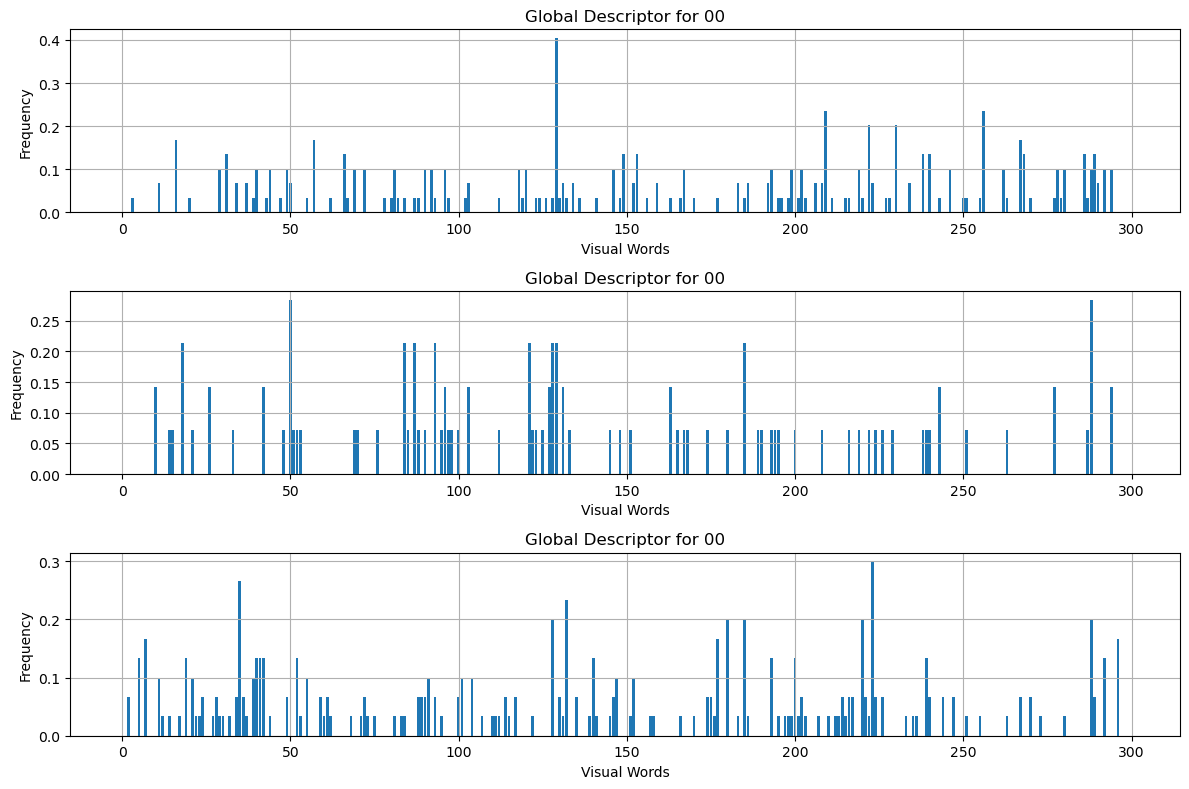

In [8]:
# Visualize global descriptors for 3 sample images
num_samples = 3
fig, axes = plt.subplots(num_samples, 1, figsize=(12, 8))

for idx in range(num_samples):
    # Select a random test image
    img_file = data_path + test_set_label[idx] + "/" + test_set[idx]
    global_descriptor = global_descriptors[idx]

    # Plot histogram
    axes[idx].bar(range(len(global_descriptor)), global_descriptor)
    axes[idx].set_title(f"Global Descriptor for {test_set_label[idx]}")
    axes[idx].set_xlabel("Visual Words")
    axes[idx].set_ylabel("Frequency")
    axes[idx].grid(True)

plt.tight_layout()
plt.show()

# V - Testing CBIR on some images (To be completed)

## Experimentation

To evaluate the usability of the method for Content-Based Image Retrieval (CBIR):
1. **Query Image Selection:**
Randomly select an image from the testing dataset to serve as the query image. The global descriptor for this image, computed during the indexing step, will be used for comparison.
2. **Similarity Computation:**
Compute the similarity or distance between the query image’s global descriptor and the global descriptors of all other images in the test dataset. Common distance metrics include:

    - Euclidean Distance: Measures the straight-line distance in descriptor space.
    - Cosine Similarity: Measures the angular similarity between descriptors.
    - Manhattan Distance: Measures the sum of absolute differences between descriptor values.
3. **Retrieve Closest Matches:**
Rank all images in the test dataset based on their similarity to the query image. Retrieve and display the top k most similar images.
4. **Visualize Results:**
Show the query image alongside the retrieved images, allowing qualitative assessment of the retrieval quality.

## Metrics for Quantitative Evaluation

To quantitatively evaluate the performance of your CBIR system, consider the following metrics:
1. Precision and Recall:
    - Precision: The proportion of retrieved images that are relevant. $ \text{Precision} = \frac{\text{Relevant Retrieved Images}}{\text{Total Retrieved Images}}$
    - Recall: The proportion of relevant images that are retrieved. $\text{Recall} = \frac{\text{Relevant Retrieved Images}}{\text{Total Relevant Images}}$
2. Mean Average Precision (mAP):
    - Calculates the average precision over multiple queries and ranks.
    - A higher mAP indicates better overall retrieval performance.
3. Distance Distribution:
    - Analyze the distribution of distances between the query and retrieved images to understand the separation between relevant and non-relevant images.

## Qualitative Analysis

Visually, the quality of retrieval can be assessed by inspecting:
- How similar the retrieved images are to the query image.
- Whether the retrieved images belong to the same class or share similar visual characteristics.
- Consistency across multiple queries.

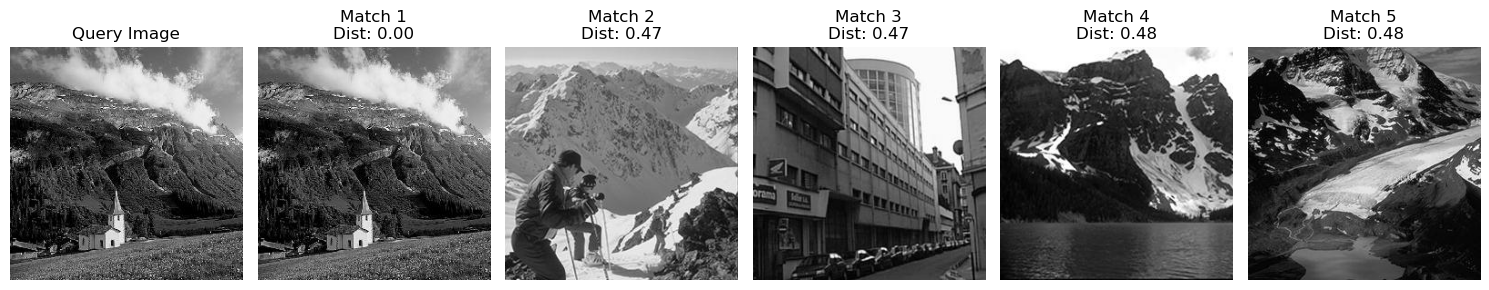

In [10]:
def retrieve_similar_images(query_index, global_descriptors, test_set, test_set_label, k=5, metric="euclidean"):
    # Query descriptor
    query_descriptor = global_descriptors[query_index].reshape(1, -1)

    # Compute distances or similarities
    if metric == "euclidean":
        distances = np.linalg.norm(global_descriptors - query_descriptor, axis=1)
    elif metric == "cosine":
        distances = 1 - cosine_similarity(global_descriptors, query_descriptor).flatten()
    else:
        raise ValueError("Unsupported metric")

    # Retrieve top-k closest images
    sorted_indices = np.argsort(distances)[:k]
    return sorted_indices, distances[sorted_indices]

# Randomly select a query image
query_index = np.random.randint(len(test_set))
query_image_file = data_path + test_set_label[query_index] + "/" + test_set[query_index]

# Retrieve top 5 similar images
k = 5
similar_indices, similar_distances = retrieve_similar_images(query_index, global_descriptors, test_set, test_set_label, k=k, metric="cosine")

# Visualize results
plt.figure(figsize=(15, 8))

# Display the query image
plt.subplot(1, k+1, 1)
query_image = cv2.imread(query_image_file)
plt.imshow(cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB))
plt.title("Query Image")
plt.axis("off")

# Display the top-k retrieved images
for i, idx in enumerate(similar_indices):
    img_file = data_path + test_set_label[idx] + "/" + test_set[idx]
    img = cv2.imread(img_file)

    plt.subplot(1, k+1, i+2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Match {i+1}\nDist: {similar_distances[i]:.2f}")
    plt.axis("off")

plt.tight_layout()
plt.show()

The retrieval results show varying levels of relevance, with some matches being closely aligned with the query image and others displaying noticeable deviations.

**Match 1 (Distance: 0.00):**
The first retrieved image is identical to the query image, confirming that the system successfully identifies the query image within the dataset. This result is expected, as the distance (or similarity score) is zero, indicating perfect alignment between the query and the retrieved image.

**Matches 2 to 5 (Distances: 0.47 to 0.48):**
The remaining retrieved images are reasonably similar to the query image in terms of visual patterns and structure, although semantic alignment varies:
•	Match 2 depicts a snowy mountain scene with people. While it is semantically distinct from the query image, it shares visual features such as mountainous elements and contrast.
•	Match 3 represents an urban street environment, which is less related to the mountain landscape in the query image. However, similar edge structures or textures may have influenced its high ranking.
•	Matches 4 and 5 show natural landscapes, including mountains and glaciers, which are closer in context to the query image compared to Match 3, yet lack the distinctive church visible in the query.

One notable strength of cosine similarity is its ability to effectively compare descriptors by evaluating their angular difference. This characteristic is particularly advantageous when working with normalized histograms, as it ensures that descriptor comparisons remain invariant to magnitude differences. This approach is well-suited for capturing global patterns in the descriptor space.

Additionally, cosine similarity demonstrates robustness in identifying structural and textural similarities, as evidenced by Matches 4 and 5. These images, despite some visual differences, share enough structural resemblance with the query to be ranked highly, underscoring the method’s capacity to discern underlying patterns in visual content.

The retrieval process, however, suffers from a noticeable semantic gap. For instance, Match 3 (an urban street) highlights a limitation in the system’s ability to interpret the semantic context of the query image. While low-level visual features such as edges and textures might align between images, the high-level semantic meaning (e.g., mountain vs. urban scene) does not.

Furthermore, there is a degree of visual ambiguity in Matches 2, 4, and 5. While these images are visually closer to the query image, they still fail to align semantically with its specific context. For example, the church in the foreground of the query image is a distinctive feature that is absent in all retrieved matches. This indicates that the system relies heavily on low-level features like texture and contrast rather than understanding or emphasizing the unique elements of the scene.